Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.1076 - val_loss: 0.8563
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7477 - val_loss: 0.6018
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5931 - val_loss: 0.5920
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5795 - val_loss: 0.5906
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5806 - val_loss: 0.5872
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5828 - val_loss: 0.5833
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5853 - val_loss: 0.5796
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5693 - val_loss: 0.5744
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5756 - val_loss: 0.5698
Epoch 10/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5746 - val_loss: 0.5663
Epoch 11/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5640 - val_loss: 0.5638
Epoch 12/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

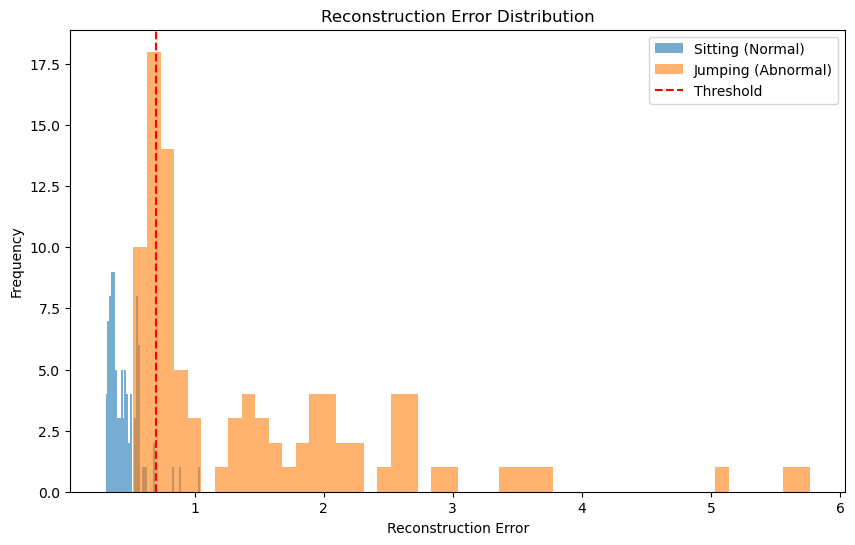

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import accuracy_score

dsa_data = pd.read_csv('./DSA_features.csv')
filtered_data = dsa_data[dsa_data['activity'].isin(['sitting', 'jumping'])]

X = filtered_data.drop(columns=['activity', 'people'])
y = filtered_data['activity'].apply(lambda x: 0 if x == 'sitting' else 1)  # sitting=0, jumping=1

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 3. train 데이터를 다시 train/validation으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# 4. training/validation에서 jumping 데이터 제거 (sitting만 사용)
X_train_sitting = X_train[y_train == 0]
X_valid_sitting = X_valid[y_valid == 0]

# 5. AE 모델
input_dim = X_train_sitting.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# AE 학습
autoencoder.fit(X_train_sitting, X_train_sitting, 
                validation_data=(X_valid_sitting, X_valid_sitting),
                epochs=500, batch_size=32, shuffle=True, verbose=1)

# 6. Reconstruction error 계산
reconstructed = autoencoder.predict(X_test)
reconstruction_error = ((X_test - reconstructed) ** 2).mean(axis=1)

# 7. Threshold 설정 및 분류
threshold = reconstruction_error[y_test == 0].mean() + 2 * reconstruction_error[y_test == 0].std()
predictions = (reconstruction_error > threshold).astype(int)  # 이상치: 1 (jumping), 정상: 0 (sitting)

# 8. Accuracy 계산
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Reconstruction error 시각화 (선택적)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error[y_test == 0], bins=50, alpha=0.6, label='Sitting (Normal)')
plt.hist(reconstruction_error[y_test == 1], bins=50, alpha=0.6, label='Jumping (Abnormal)')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()